In [1]:
#Constructing Gates
#Amitava Chakraborty - 23th July 2018
from qiskit import IBMQ
# Loading your IBM Q account(s)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
# Useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

u_backend = BasicAer.get_backend('unitary_simulator')
s_backend = BasicAer.get_backend('statevector_simulator')
q_backend = BasicAer.get_backend('qasm_simulator')

We have a qubit $q0$. We shall apply two Pauli gates,<br>
$\sigma_x = \left|0\right\rangle\left\langle{1}\right|+\left|1\right\rangle\left\langle{0}\right|$
and
$\sigma_y = i\left|1\right\rangle\left\langle{0}\right|-i\left|0\right\rangle\left\langle{1}\right|$
and then see the unitary value of the overall operator and the state vector. <br>
i.e., The Pauli-X gate, 
$\sigma_x = \begin{pmatrix} 0 & 1\\1 & 0 \end{pmatrix}$
and the Pauli-Y gate, 
$\sigma_y = \begin{pmatrix} 0 & -i\\i & 0 \end{pmatrix}$
 operates on the state <br>
$|0> = \begin{pmatrix} 1\\0 \end{pmatrix}$ to produce a final state vector.
$|\psi> = \begin{pmatrix} 1\\0 \end{pmatrix}$ which is same as $|0>$


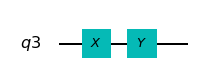

In [9]:
#Let us create an arbitrary single-qubit operation
q = QuantumRegister(1)

#Apply an X-Gate
#Then a Y-Gate
qc = QuantumCircuit(q)
qc.x(q[0])
qc.y(q[0])
#qc.barrier(q[0])
qc.draw(output='mpl')

In [12]:
#How the overall unitary operator looks like
u_job = execute(qc, u_backend)
u=u_job.result().get_unitary(qc, decimals=3)

#What about the resultant statevector?
s_job = execute(qc, s_backend)
s=s_job.result().get_statevector(qc, decimals=3)
print('Unitary Operator : ',u)
print('State Vector : ',s)

Unitary Operator :  [[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]
State Vector :  [1.+0.j 0.+0.j]


So how to deduce the unitary operator of these two gates? <br>
The matrix multiplication of <br>
$\sigma_x = \begin{pmatrix} 0 & 1\\1 & 0 \end{pmatrix}$
and 
$\sigma_y = \begin{pmatrix} 0 & -i\\i & 0 \end{pmatrix}$
is<br>
$|U> = YX = \begin{pmatrix} 0 & -i\\i & 0 \end{pmatrix}\begin{pmatrix} 0 & 1\\1 & 0 \end{pmatrix}$
i.e., $|U> = \begin{pmatrix} -i & 0\\0 & i \end{pmatrix}$

 operates on the state <br>
$|0> = \begin{pmatrix} 1\\0 \end{pmatrix}$ to produce a final state vector.
$|\psi> = \begin{pmatrix} 1\\0 \end{pmatrix}$ which is same as $|0>$

To apply a matrix to a vector, therefore, we follow the same matrix multiplication procedure described above. We manipulate qubits in our quantum computer by applying sequences of quantum gates. Each quantum gate can be expressed as a matrix that can be applied to state vectors, thus changing the state. 


This gate acts similarly to the classical NOT logic gate. It maps the computational basis state 
$|0⟩$ to $|1⟩$ and $|1⟩$ to $|0⟩$ - "flips" the state.
                                                                    

In [13]:
# So how did we get the above State Vector?
#input two matrices 
q0 = ([1.+0.j, 0.+0.j])  #1-dim
X = ([0.+0.j, 1.-0.j],[1.+0.j, 0.+0.j]) 
# X operates on q0
result = np.dot(X,q0) 
print('X|0> : ',result) 
#We expected a bit-flip, and we got one

#Now Y operates on result
Y = ([0.+0.j, -0.-1.j],[ 0.+1.j,  0.+0.j])
result = np.dot(Y,result) 
print('Y(X|0>) : ',result)
#We expected a bit and phase-flip and we got one
#But it is not the same state vector that we got by running the job in a statevector simulator

#Now let us take the unitary of our circuit and perform the dot product
result = np.dot(u,q0)
print('U|0> : ',result)
result = np.dot(Y,X)
print(result)
#We see that we have our state vector
#So the entire unitary operator consisting of all the gates is actually working on the initial value of the qubit.

#But in case there is a barrier between the gates, the gates are applied one (or those grouped within a barrier) at a time

X|0> :  [0.+0.j 1.+0.j]
Y(X|0>) :  [0.-1.j 0.+0.j]
U|0> :  [1.+0.j 0.+0.j]
[[0.-1.j 0.+0.j]
 [0.+0.j 0.+1.j]]


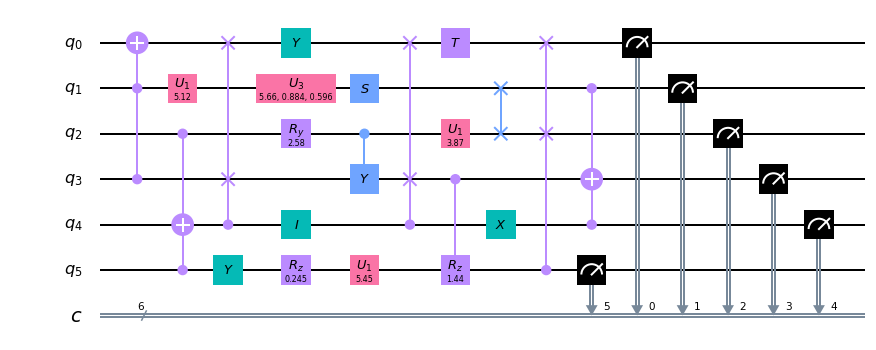

In [14]:
#A Random Circuit
from qiskit.circuit.random import random_circuit
qc = random_circuit(6,6, max_operands=3, measure=True)
qc.draw('mpl')

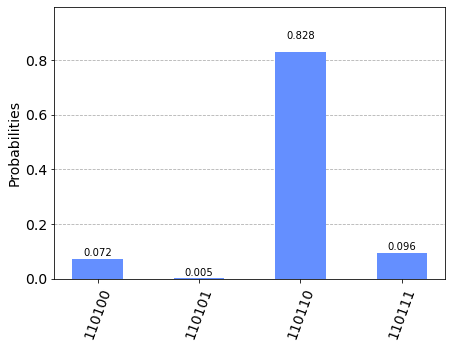

In [15]:
results = execute(qc, backend=q_backend, shots=2000).result()
plot_histogram(results.get_counts())

# Higher Order Control Gates

Many quantum algorithms require higher order control gates. We define our own function for constructing higher order control gates. 

The Strategy - we will use only CCNOT and CNOT gates. We must use the conditions on N qubits in order to invoke a single operation. A single CCNOT gate can only take two control qubits at a time - so the trick is to use ancilla qubits. These ancilla qubits will allow us to temporarily store information about the control qubits, and ultimately determine whether or not to apply the operation. 



In [14]:
# A CCCC_NOT Gate
def CCCC_NOT(state):
    q=state
    ancilla = []
    for i in np.arange(2):
        s = 2*i
        if q[s]==1 and q[s+1]==1:
            ancilla.append(1)
        else:
            ancilla.append(0)
    return(ancilla)

# ’state1’ results in the state of all 1’s for the ancilla system
state1 = [1,1,1,1]
print('state 1 :', state1, ' ancilla 1: ', CCCC_NOT(state1))
# ’state2’ results in a 0 for the second ancilla qubit. 
# If we use these two ancilla qubits as the control qubits for a CCNOT, 
# the first system wouldreceive the operation, while the second wouldn’t. If we compare this result to our initial states, we would have achieved exactlya 4-qubit control gate: the state|1111〉receives the operation while the state|1110〉does not.
state2 = [1,1,1,0]
print('state 2 :', state2, ' ancilla 2: ', CCCC_NOT(state2))

    

state 1 : [1, 1, 1, 1]  ancilla 1:  [1, 1]
state 2 : [1, 1, 1, 0]  ancilla 2:  [1, 0]


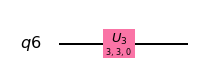

In [20]:
#Let us create an arbitrary single-qubit operation
q = QuantumRegister(1)

#Apply an X-Gate
#Then a Y-Gate
qc = QuantumCircuit(q)
qc.u3(3,3,0,q[0])
#qc.u3(3,3,3,q[0])
#qc.barrier(q[0])
qc.draw(output='mpl')

In [21]:
#How the overall unitary operator looks like
u_job = execute(qc, u_backend)
u=u_job.result().get_unitary(qc, decimals=3)

#What about the resultant statevector?
s_job = execute(qc, s_backend)
s=s_job.result().get_statevector(qc, decimals=3)
print('Unitary Operator : ',u)
print('State Vector : ',s)

Unitary Operator :  [[ 0.071+0.j    -0.997+0.j   ]
 [-0.988+0.141j -0.07 +0.01j ]]
State Vector :  [ 0.071+0.j    -0.988+0.141j]


In [19]:
#How the overall unitary operator looks like
u_job = execute(qc, u_backend)
u=u_job.result().get_unitary(qc, decimals=3)

#What about the resultant statevector?
s_job = execute(qc, s_backend)
s=s_job.result().get_statevector(qc, decimals=3)
print('Unitary Operator : ',u)
print('State Vector : ',s)

Unitary Operator :  [[ 0.071+0.j     0.988-0.141j]
 [-0.988+0.141j  0.068-0.02j ]]
State Vector :  [ 0.071+0.j    -0.988+0.141j]
